![data cube logo](https://static.wixstatic.com/media/8959d6_a13dc7ece5be4678af57c8f7c1667734~mv2.png/v1/fill/w_279,h_177,al_c,q_85,usm_0.66_1.00_0.01,enc_auto/VSDC_DataCubeSplash_6Partner_edited.png)
# Random Forest and a Mosquito Habitat Suitability Index (HSI) in City of Chesapeake, Virginia

- Sign up to the [VA Datacube](https://www.data4va.org/) to run this notebook interactively from a browser

## This notebook aims to model a Habitat Suitability Index (HSI) for a mosquito species (*Culiseta melanura*) based on June 2020 data in City of Chesapeake with following steps:

1. Import necessary python packages
2. Clean up mosquito data
3. Train a Random Forest Regression model
4. Display the regression model result
5. Create an interactive map for the modeling outcome 

Data Sources: 
- Mosquito light trap data /  Chesapeake Mosquito Control Commission (https://www.cityofchesapeake.net/1205/Mosquito-Control-Commission)
- Landsat 8 remote sensed image / USGS Earth Explorer (https://earthexplorer.usgs.gov/)
- Soil Geographic Databases / USDA Geospatial Data Gateway (https://datagateway.nrcs.usda.gov/GDGHome_DirectDownLoad.aspx)
- Water Body / Chesapeake Open Data (https://public-chesva.opendata.arcgis.com/datasets/chesva::water-bodies/explore)

Reference: 
- Bellow, A. S. (2007) Modeling Habitat and Environmental Factors Affecting Mosquito Abundance in Chesapeake, Virginia. Doctoral dissertation, Old Dominion University.
- Cleckner, H. L. (2010) Spatial Modeling of the Risk of Mosquito-Borne Disease Transmission, Chesapeake, Virginia. Master's thesis, East Carolina University.
- Baig, M. H. A., Zhang, L., Shuai, T., & Tong, Q. (2014). Derivation of a tasselled cap transformation based on Landsat 8 at-satellite reflectance. Remote Sensing Letters, 5(5), 423-431.

## 1. Import required packages

In [5]:
import os
import sys
import datacube
import pandas as pd
import numpy as np

# Machine learning package
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz

# Plotting & mapping package
import matplotlib.pyplot as plt
%matplotlib inline
from osgeo import osr,gdal
import rioxarray as rxr
import folium
from folium import plugins
import branca

## 2. Loading and mosquito data clean up 
The mosquito data was obtained from the Chesapeake Mosquito Control Commission. Data was compiled into the average trapping counts for each trap sites for a mosquito species *Culiseta melanura*.

In [2]:
path = "./Mosquito_Data"

# Load the mosquito trap data as a pandas dataframe
mosquitodf = pd.read_csv(path + "/" + "mosquite_2020_June_mean_CPCData_variables.csv")

# Clean-up the dataframe
mosquitodf = mosquitodf[['Trap ID', 'Cs melanura_mean', 'w_body', 'w_storage',
                         'w_t_depth', 'runoff', 'drain', 'hyd_soil', 'TC1', 'TC2', 'TC3']] # keep necessary columns
mosquitodf.columns = ['Trap_ID', 'Cs_melanura_mean', 'WaterBody', 'WaterStorage',
                      'WaterTableDepth', 'RunoffClass', 'DrainClass', 'HydricSoil', 'TC1', 'TC2', 'TC3'] # reassign proper column names 

mosquitodf.head()

,Trap_ID,Cs_melanura_mean,WaterBody,WaterStorage,WaterTableDepth,RunoffClass,DrainClass,HydricSoil,TC1,TC2,TC3
0,CMCC004,609.0,0,3.64,7,1.0,5,1,0.353525,0.207076,0.060931
1,CMCC003,261.5,0,3.32,38,0.8,4,1,0.346784,0.199572,0.048538
2,CMCC005,8.0,0,3.40,15,1.0,4,1,0.446825,0.076815,-0.046800
3,CMCC006,595.0,0,3.40,15,1.0,4,1,0.345870,0.130171,0.007554
4,CMCC009,364.0,0,3.64,7,1.0,5,1,0.339426,0.184700,0.042988


### Column definitions: 
- Trap ID: A unique ID for each trap site
- Dependent variable:
    - Cs melanura_mean : The monthly average number of Culiseta melanura trapped in the site
- Independent variables (based on the studies of Bellow, A. S. (2007) and Cleckner, H. L. (2010)): 
    - WaterBody : The open water bodies in City of Chesapeake.
    - WaterStorage : Maximum value for the range of available water in plant root zones, 25 cm is selected here.
    - WaterTableDepth : Minimum value for the range in depth to the seasonally high water table April-June. The unit is feet.
    - RunoffClass : Degree of potential water loss by overland flow.
    - DrainClass : Degree of hydraulic conductivity and low water-holding capacity.
    - HydricSoil : Soil meets requirements for hydric soil.
    - TC1 : Tassel Cap Transformation 1 for Brightness.
    - TC2 : Tassel Cap Transformation 2 for Greenness.
    - TC3 : Tassel Cap Transformation 3 for Wetness.

### Next we will explore the mosquito count data with a data transformation.

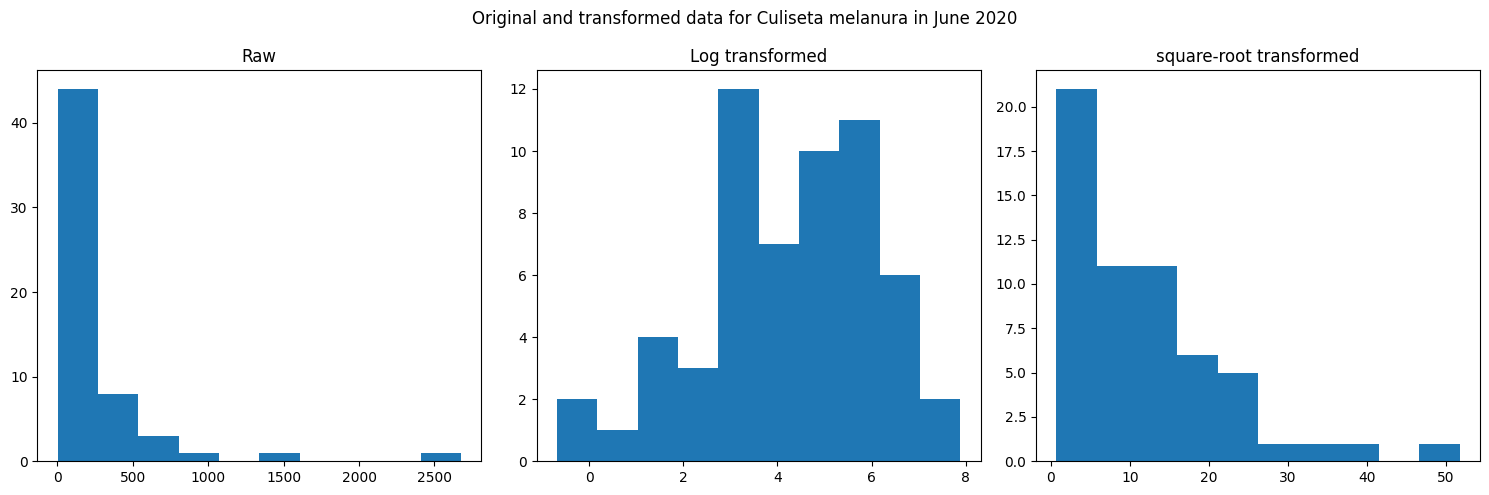

In [7]:
# Aplly two typical transformation methods to the original count numbers.
mosquitodf ["Cs_melanura_log"] = np.log(mosquitodf ["Cs_melanura_mean"])
mosquitodf ["Cs_melanura_sqrt"] = np.sqrt(mosquitodf ["Cs_melanura_mean"])

# Make a side-by-side figure to compare their difference.
fig, axs = plt.subplots(1, 3, figsize=(15, 5),tight_layout=True)
fig.suptitle('Original and transformed data for Culiseta melanura in June 2020')
axs[0].hist(mosquitodf ["Cs_melanura_mean"])
axs[0].set_title("Raw")
axs[1].hist(mosquitodf ["Cs_melanura_log"])
axs[1].set_title("Log transformed")
axs[2].hist(mosquitodf ["Cs_melanura_sqrt"])
axs[2].set_title("square-root transformed")

plt.show()

Following model will build based on the log transformed data. 
> Note that there are various transformation methods. As this notebook is for demonstration purpose, please be aware of the limitation of log transformation or any transformation techniques apply to data. 

## 3. Run Random Forest Regression model
First, splitting data into training and testing data based on 25/75 ratio, then, calling the Random Forest package to train the model. 

In [4]:
# Define the independent variable and create an array
d_variable = "Cs_melanura_log"
labels = np.array(mosquitodf[d_variable])

# Create a new dataframe for independent variables only
independdf = mosquitodf[['WaterBody', 'WaterStorage','WaterTableDepth', 'RunoffClass', 'DrainClass', 'HydricSoil', 'TC1', 'TC2', 'TC3']]
independ_list = list(independdf.columns)

In [5]:
# Split the dataset to test and traning data based on 25/75 percent ratio 
train_features, test_features, train_labels, test_labels = train_test_split(independdf, labels, test_size = 0.25, random_state = 42)

In [6]:
# Set-up random forest model and train the model
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(train_features, train_labels);

## 4. Investigate the outcomes and apply model to predict the HSI for the City of Chesapeake

In [7]:
# Make predicition and compute the absolute error
predictions = rf.predict(test_features)
errors = abs(predictions - test_labels)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'mosquito counts (values are transformed)')

Mean Absolute Error: 1.44 mosquito counts (values are transformed)


In [8]:
# Determine Performance Metrics 
mape = 100 * (errors / test_labels)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 62.85 %.


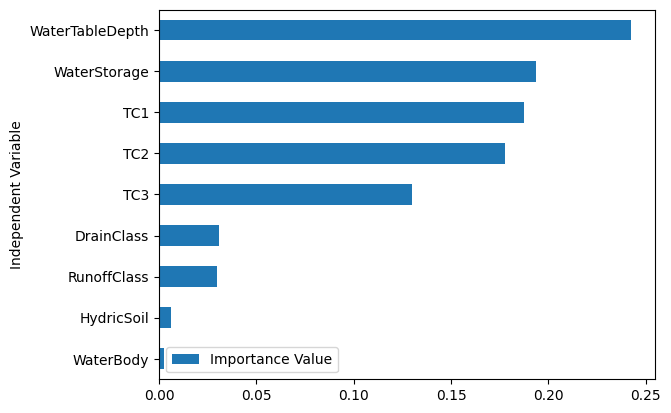

In [9]:
# Demonstrate the importance of each indepent variables in order
importances = list(rf.feature_importances_)
importancedf = pd.DataFrame(zip(independ_list, importances), 
                            columns=['Independent Variable', 'Importance Value']).sort_values('Importance Value', ascending = True)

# Create a figure to show the importance values
ax = importancedf.plot.barh(x = "Independent Variable", y = "Importance Value" )

The chart for importance values giving the idea of which variables have the more contribution than others.

In [10]:
# Load Geotiff files that cover the City of Chesapeake to a pandas dataframe
fullVariablesDataFrame = pd.DataFrame()

for variable in independ_list:
    variableraster = gdal.Open("./Mosquito_Data/" + variable + ".tif")
    variablearray = variableraster.GetRasterBand(1).ReadAsArray().flatten()
    fullVariablesDataFrame[variable] = variablearray

In [11]:
# Use the trained Random Forest model to predict HSI values
class_prediction = rf.predict(fullVariablesDataFrame) # This step take little bit longer

In [12]:
# Utilize a tif file for geospatial reference, here we use one of the independent variable layers (TC1.tif)
referenceDataset = gdal.Open("./Mosquito_Data/TC1.tif")
out_geotransform = referenceDataset.GetGeoTransform()
out_projection = referenceDataset.GetProjection()
out_nrows = referenceDataset.RasterYSize
out_ncols = referenceDataset.RasterXSize

In [13]:
# Reshape the predicted HSI array and inverse the log transformation
shape_prediction = np.reshape(class_prediction,(out_nrows,out_ncols))
shape_prediction_original = np.exp(shape_prediction) # change to different function if other transformation method was applied

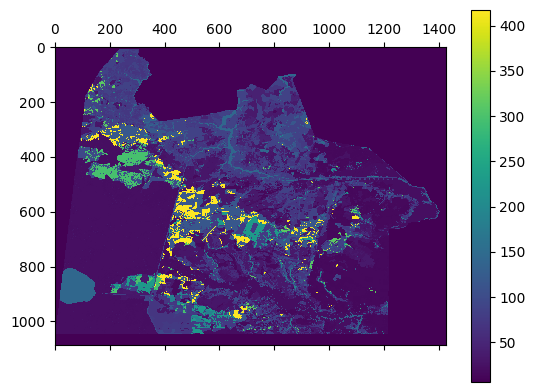

In [14]:
# Create a quick display for the predicted HSI values
plt.matshow(shape_prediction_original)
plt.colorbar()

In [15]:
# Create an empty GeoTiff file before writing the predicted HSI values
driverTiff = gdal.GetDriverByName('GTiff')
outname   = 'Predited_mosquito_classified.tif'
if os.path.isfile(outname): os.remove(outname)

mosquitoClassDataset = driverTiff.Create(
    outname,
    out_ncols,
    out_nrows,
    1,
    gdal.GDT_Float32
  )

In [16]:
# Write the predicted HSI values to the GeoTiff
mosquitoClassDataset.SetGeoTransform(out_geotransform)
mosquitoClassDataset.SetProjection(out_projection)
mosquitoBand = mosquitoClassDataset.GetRasterBand(1)
mosquitoBand.WriteArray(shape_prediction_original)
mosquitoBand.FlushCache()

del mosquitoClassDataset
#mosquitoData=None

## 5. Creare an interactive map to display the HSI for the City of Chesapeake


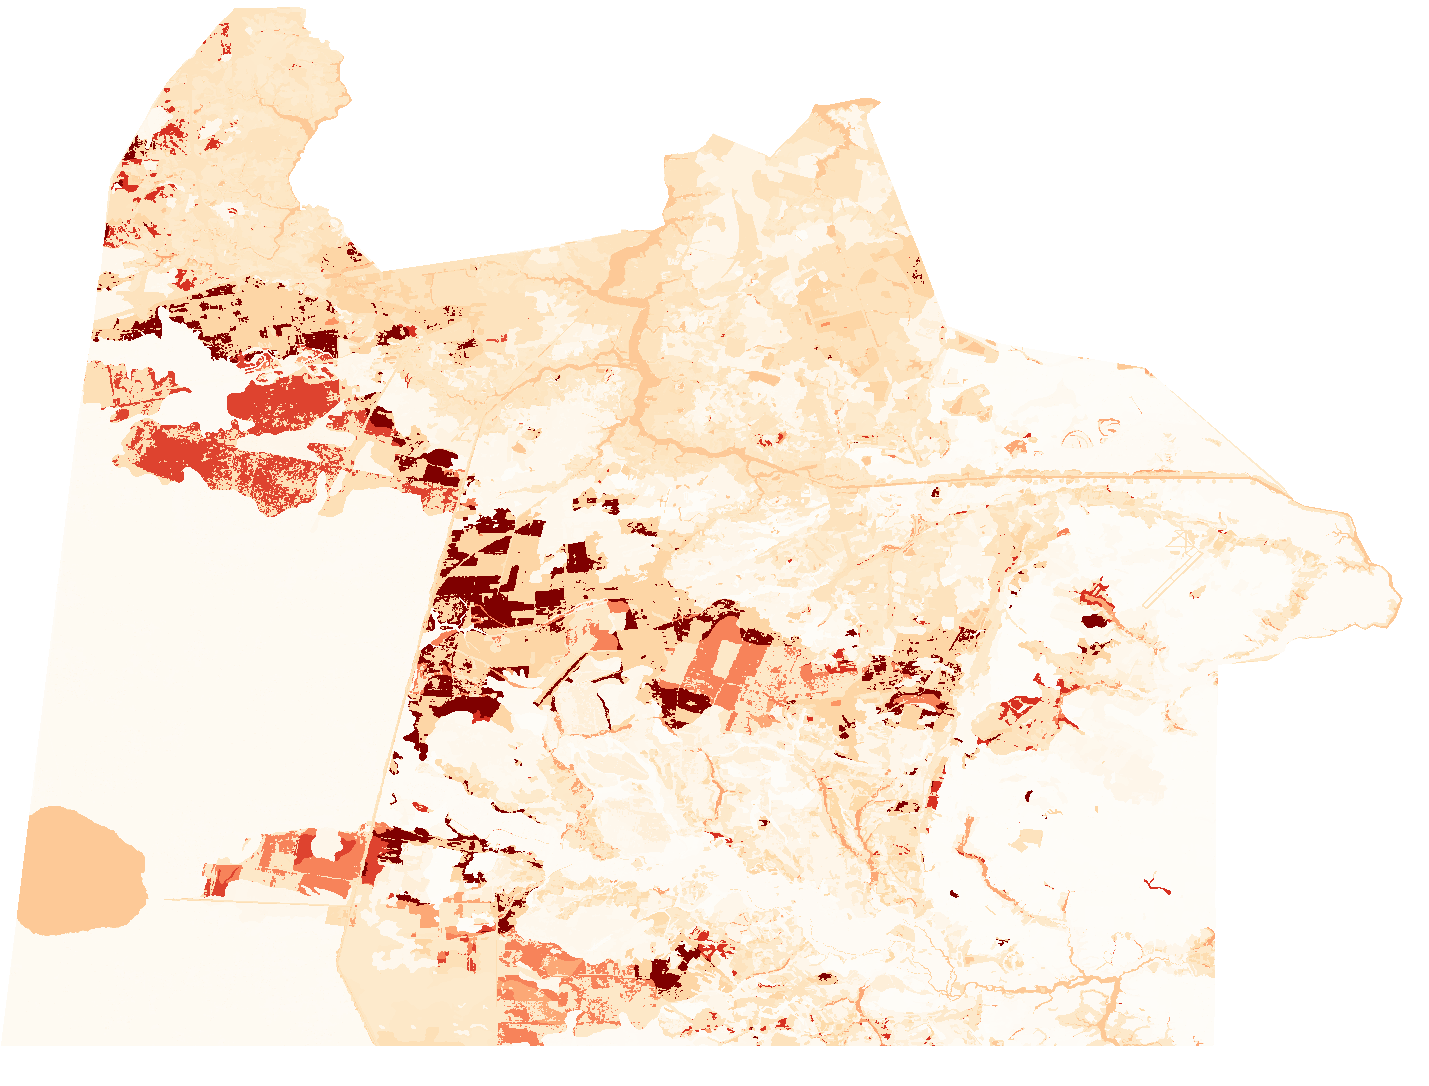

In [17]:
# Create a folium map 
m = folium.Map(location=[36.72, -76.30], zoom_start=11, tiles="cartodbpositron")

# Call two basemap layers and add to the map
basemaps = {
    'Google Maps': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Maps',
        overlay = True,
        control = True
    ),
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    )
}
basemaps['Google Maps'].add_to(m)
basemaps['Google Satellite'].add_to(m)

# Open the HSI GeoTiff file
predicttif = rxr.open_rasterio("./Predited_mosquito_classified.tif").drop('band')[0]
mlat = predicttif.y.values.min()
mlon = predicttif.x.values.min()
xlat = predicttif.y.values.max()
xlon = predicttif.x.values.max()

# Define a color scheme and create a function to colorize raster file.
cmap = "OrRd"
def colorize(array, cmap= cmap):
    normed_data = (array - array.min()) / (array.max() - array.min())    
    cm = plt.cm.get_cmap(cmap)    
    return cm(normed_data)

# Add colorized data to folium map
arr_predicttif = predicttif.values
data         = np.ma.masked_invalid(arr_predicttif)
colored_data = colorize(data, cmap=cmap)
folium.raster_layers.ImageOverlay(colored_data,
                                  [[mlat, mlon], [xlat, xlon]],
                                  name= "Predicted counts for Culiseta melanura",
                                  opacity=0.75).add_to(m)

# Define color index for legend
arrmax = arr_predicttif.max()
arrmin = arr_predicttif.min()
interval = (arrmax-arrmin) / 5 # assuming using the equal interval for plotting
color_index = [arrmin, arrmin+interval,arrmin+interval*2, arrmin+interval*3, arrmin+interval*4, arrmax]

# Add a legend to folium map
colorlegend = branca.colormap.linear.OrRd_09.scale(arrmin, arrmax) # replace OrRd_09 if change the color scheme use
colorlegend = colorlegend.to_step(index=color_index)
colorlegend.caption = "Predicted Culiseta melanura count in June 2020"
colorlegend.add_to(m)
svg_style = '<style>svg#legend {background-color: white;}</style>' # this svg style improve the visualization of legend
m.get_root().header.add_child(folium.Element(svg_style))

# Add a layer control panel to the map, you can on/off layers from the top-right corner icon
m.add_child(folium.LayerControl())

m

***
## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 


**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** June 2023

**Compatible datacube version:** 

In [6]:
print(datacube.__version__)

1.8.13


## Tags 
Browse all available tags on the VA Data Cube User Guide's Tags Index 